# Weight Decay

In [1]:
!pip install mxnet
!pip install d2l

Traceback (most recent call last):
  File "/home/iserina/.local/bin/pip", line 7, in <module>
    from pip._internal import main
ModuleNotFoundError: No module named 'pip._internal'
Traceback (most recent call last):
  File "/home/iserina/.local/bin/pip", line 7, in <module>
    from pip._internal import main
ModuleNotFoundError: No module named 'pip._internal'


In [9]:
!pip install d2l\
!pip install mxnet

%matplotlib inline
import d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

## High-dimensional Linear Regression

$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01)$$

In [11]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 1
true_w, true_b = nd.ones((num_inputs, 1)) * 0.01, 0.05

train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

## Weight Decay from Scratch

### Initialize Model Parameters

In [12]:
def init_params():
    w = nd.random.normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    w.attach_grad()
    b.attach_grad()
    return [w, b]

### Define Squared $\ell_2$ Norm Penalty

In [13]:
def l2_penalty(w):
    return (w**2).sum() / 2

### Define Training and Testing

In [14]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], legend=['train', 'test'])
    for epoch in range(1, num_epochs+1):
        for X, y in train_iter:
            with autograd.record():
                # The L2 norm penalty term has been added
                l = loss(net(X), y) + lambd * l2_penalty(w)
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        if epoch % 5 == 0:
            animator.add(epoch+1, (d2l.evaluate_loss(net, train_iter, loss),
                                   d2l.evaluate_loss(net, test_iter, loss)))
    print('l2 norm of w:', w.norm().asscalar())

### Training without Regularization

l2 norm of w: 14.358259


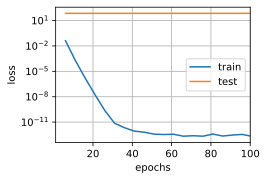

In [15]:
train(lambd=0)

### Using Weight Decay

l2 norm of w: 0.03281139


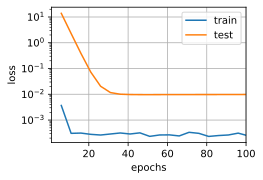

In [16]:
train(lambd=3)

## Weight Decay in Gluon
Because weight decay is ubiquitous in neural network optimization, Gluon makes it especially convenient, integrating weight decay into the optimization algorithm itself for easy use in combination with any loss function. Moreover, this integration serves a computational benefit, allowing implementation tricks to add weight decay to the algorithm, without any additional computational overhead. Since the weight decay portion of the update depends only on the current value of each parameter, and the optimizer must to touch each parameter once anyway.

In the following code, we specify the weight decay hyper-parameter directly through the wd parameter when instantiating our Trainer. By default, Gluon decays both weights and biases simultaneously. Note that we can have different optimizers for different sets of parameters. For instance, we can have one Trainer with weight decay for the weights 𝐰 and another without weight decay to take care of the bias 𝑏

In [19]:
def train_gluon(wd):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=1))
    loss = gluon.loss.L2Loss()
    num_epochs, lr = 100, 0.003
    # The weight parameter has been decayed. Weight names generally end with
    # "weight".
    trainer_w = gluon.Trainer(net.collect_params('.*weight'), 'sgd',
                              {'learning_rate': lr, 'wd': wd})
    # The bias parameter has not decayed. Bias names generally end with "bias"
    trainer_b = gluon.Trainer(net.collect_params('.*bias'), 'sgd',
                              {'learning_rate': lr})
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], legend=['train', 'test'])
    for epoch in range(1, num_epochs+1):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            # Call the step function on each of the two Trainer instances to
            # update the weight and bias separately
            trainer_w.step(batch_size)
            trainer_b.step(batch_size)
        if epoch % 5 == 0:
            animator.add(epoch+1, (d2l.evaluate_loss(net, train_iter, loss),
                                   d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', net[0].weight.data().norm().asscalar())


### Using Weight Decay

L2 norm of w: 12.705354


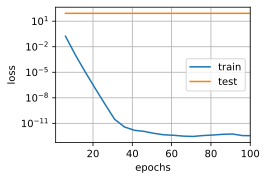

In [20]:
train_gluon(wd=0)

### Training without Regularization

L2 norm of w: 0.035495266


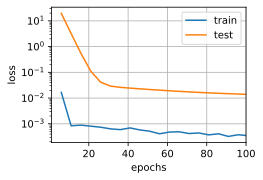

In [21]:
train_gluon(wd=3)

In [ ]:
## Weight Decay in Keras


In [60]:
import pandas as pd

import numpy as np
import keras

from matplotlib import pyplot as plt

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras import initializers

from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

%matplotlib inline

In [77]:
num_epochs, lr = 100, 0.003

X_=train_data[0].asnumpy()
y_=train_data[1].asnumpy()

tX_=test_data[0].asnumpy()
ty_=test_data[1].asnumpy()

wd=10

inputs = Input(shape=(num_inputs,))
preds = Dense(1,kernel_regularizer=regularizers.l2(wd),kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.001))(inputs)

model = Model(inputs=inputs,outputs=preds)
sgd=keras.optimizers.SGD()
model.compile(optimizer=sgd ,loss='mse',metrics=['mse'])
history =model.fit(X_,y_, batch_size=batch_size, epochs=num_epochs,validation_data=(tX_, ty_), shuffle=False)

Train on 20 samples, validate on 100 samples
Epoch 1/100
20/20 [==============================] - 1s 28ms/step - loss: 0.0687 - mean_squared_error: 0.0229 - val_loss: 0.0465 - val_mean_squared_error: 0.0230
Epoch 2/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0589 - mean_squared_error: 0.0184 - val_loss: 0.0452 - val_mean_squared_error: 0.0218
Epoch 3/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0582 - mean_squared_error: 0.0183 - val_loss: 0.0463 - val_mean_squared_error: 0.0213
Epoch 4/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0578 - mean_squared_error: 0.0183 - val_loss: 0.0476 - val_mean_squared_error: 0.0210
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0578 - mean_squared_error: 0.0183 - val_loss: 0.0487 - val_mean_squared_error: 0.0209
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0578 - mean_squared_error: 0.0183 - val_loss: 0.0497 - val_mean_squared_er

20/20 [==============================] - 0s 3ms/step - loss: 0.0586 - mean_squared_error: 0.0186 - val_loss: 0.0527 - val_mean_squared_error: 0.0210
Epoch 52/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0586 - mean_squared_error: 0.0186 - val_loss: 0.0527 - val_mean_squared_error: 0.0210
Epoch 53/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0586 - mean_squared_error: 0.0186 - val_loss: 0.0527 - val_mean_squared_error: 0.0210
Epoch 54/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0586 - mean_squared_error: 0.0186 - val_loss: 0.0527 - val_mean_squared_error: 0.0210
Epoch 55/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0586 - mean_squared_error: 0.0186 - val_loss: 0.0527 - val_mean_squared_error: 0.0210
Epoch 56/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0586 - mean_squared_error: 0.0186 - val_loss: 0.0527 - val_mean_squared_error: 0.0210
Epoch 57/100
20/20 [=====================

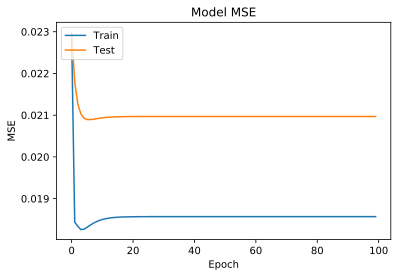

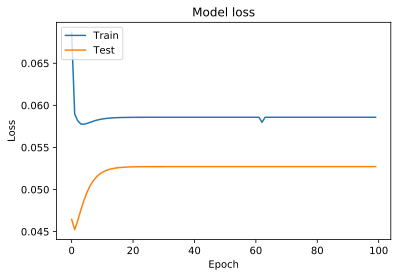

In [78]:
# Plot training & validation accuracy values
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [73]:
history.params

{'batch_size': 1,
 'epochs': 100,
 'steps': None,
 'samples': 20,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss',
  'mean_squared_error',
  'val_loss',
  'val_mean_squared_error']}

In [ ]:
# KERAS IMPLEMENTATION
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers, initializers, optimizers

# Representing features as numpy vectors
train_features = train_features.asnumpy()
test_features = test_features.asnumpy()
train_labels = train_labels.asnumpy()
test_labels = test_labels.asnumpy()

In [ ]:
model = Sequential()
model.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=1),
                kernel_regularizer=regularizers.l2(1), input_shape=(200,)))
sgd = optimizers.SGD()
model.compile(optimizer=sgd, loss='mean_squared_error')
history = model.fit(train_features, train_labels, epochs=100, verbose=2, validation_split=0.2)
test_predictions = model.predict(test_features)

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()